## Importing the data first

In [86]:
import gzip
import json
import pandas as pd

filename="goodreads_reviews_poetry_cleaned.json.gz"

with gzip.GzipFile(filename, 'r',) as fin:
    data=[]
    for line in fin:
        info=json.loads(line.decode('utf-8'))
        new_info={}
        new_info['user_id']=info['user_id']
        new_info['book_id']=info['book_id']
        new_info['rating']=info['rating']
        new_info['date']=info['date']
        data.append(new_info)

In [77]:
data[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '29893493',
 'rating': 5,
 'date': 'Sun Mar 12 23:33:51 -0700 2017'}

In [3]:
data[0]['date']

'Sun Mar 12 23:33:51 -0700 2017'

## Build two dictionaries that map from user_id/book_id to new integer values

user_map = {user_id to user_index}

book_map = {book_id to book_index}
 

## Exploration

Build histogram that shows how many users have between 0-5 ratings, 6-10 ratings, etc

In [87]:
import matplotlib.pyplot as plt
import numpy as np

user_to_num_ratings={}
for rating in data: 
    if rating['user_id'] not in user_to_num_ratings:
        user_to_num_ratings[rating['user_id']]=1
    else:
        user_to_num_ratings[rating['user_id']]+=1

In [88]:
counts=[]
for user in user_to_num_ratings:
    counts.append(user_to_num_ratings[user])
counts=np.array(counts)

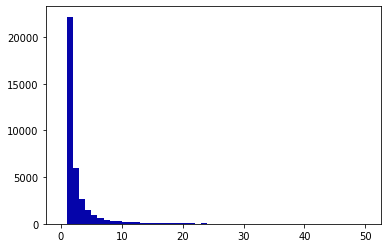

In [89]:
n, bins, patches = plt.hist(x=counts, bins=50, range=(0,50), color='#0504aa')

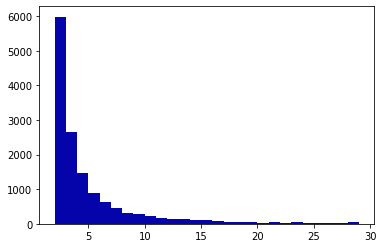

In [95]:
n, bins, patches = plt.hist(x=counts, bins=[i for i in range(2,30)], range=(2,30), color='#0504aa')

In [91]:
max(counts)

1062

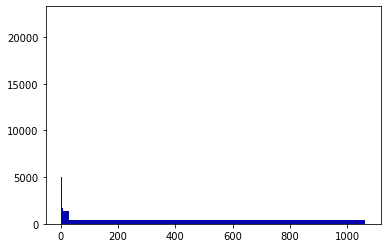

In [105]:
n, bins, patches = plt.hist(x=counts, bins=[1,2,3,6,10,30,1062], color='#0504aa')

In [108]:
print(n)
print(n/sum(n))

[22173.  5984.  5012.  1701.  1398.   368.]
[0.60522437 0.16333661 0.13680533 0.04642974 0.03815919 0.01004476]


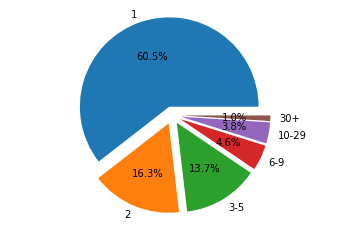

In [109]:
labels=["1","2","3-5","6-9","10-29","30+"]
sizes=n/sum(n)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=[0.1 for i in range(6)],labels=labels, autopct='%1.1f%%')
ax1.axis('equal') 
plt.show()


<BarContainer object of 6 artists>

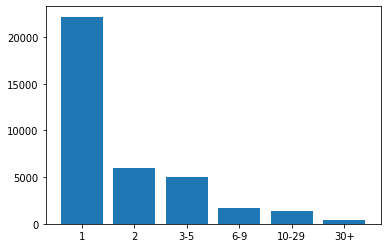

In [110]:
plt.bar(labels,n)

## Separate the training and testing sets

For users that have at least 5 ratings, testing dataset is most recent floor(0.2 x number of ratings) ratings

For users that have 2-4 ratings, use most recent rating as testing. Also include a flag that notes if user has at least 5 ratings or not.

For training, make sure format is dictionary of "book_ids": list,"user_ids": list,"ratings": list

For testing, have dictionary of category to user (like "0-5 ratings":list of lists of userid,bookid,rating, etc)

In [111]:
# Build dictionary of user -> [(date,bookid,rating),
def interpret_date_string(date_string):
    split=date_string.split(' ')
    output_str=split[-1]
    month_to_num={"Jan":"01","Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07",
                 "Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"}
    output_str=output_str+month_to_num[split[1]]+split[2]
    return int(output_str)
    
user_info={}
for rating in data:
    if rating['user_id'] not in user_info:
        user_info[rating['user_id']]=[]
    user_info[rating['user_id']].append((interpret_date_string(rating['date']),rating['book_id'],rating['rating']))
# Dictionary from user id to list of lists of date,bookid,rating

c=0
for user in user_info:
    print(user,user_info[user])
    c+=1
    if c==10:
        break

3ca7375dba942a760e53b726c472a7dd [(20120615, '402128', 5)]
0ef32090550901ead25cb0ea21c4d36b [(20140414, '92270', 5)]
d37b46b2190ed7c518259f29b47a9b36 [(20170930, '253264', 5)]
f4c6fe33ef61c38f7f4aeb5224c259a5 [(20130507, '13105527', 5)]
4672eb229c808b792b8ea95f01f19784 [(20141011, '1420', 1), (20160113, '1381', 3)]
b54c83f02c748fe75ed309e1e12eace2 [(20121014, '15787122', 3)]
f88032f4ad97b46654fe59ce3387cf5d [(20151017, '23668465', 4), (20140323, '18600808', 0), (20141230, '18745066', 4), (20131217, '1215884', 3), (20160217, '18141482', 5), (20130702, '3049', 2)]
f2f95653b98e1a4a68c3beab1a7f8f5e [(20160330, '704880', 5)]
7e4945a6266566e39e3f251fff0fdde1 [(20140912, '128436', 5)]
6665fe2d574221577f8a5483a6f17844 [(20160225, '11958313', 5)]


In [114]:
# Categories of number of ratings: "2","3-5","6-9","10-29","30+"
training={"book_ids":[],"user_ids":[],"ratings":[]}
testing={"2":[],"3-5":[],"6-9":[],"10-29":[],"30+":[]}
for user in user_info:
    l=len(user_info[user])
    user_info[user].sort()
    if l==2:
        training["book_ids"].append(user_info[user][0][1])
        training["user_ids"].append(user)
        training["ratings"].append(user_info[user][0][2])
        testing["2"].append([user,user_info[user][1][1],user_info[user][1][2]])
    elif 3<=l<=5:
        for i in range(l-1):
            training["book_ids"].append(user_info[user][i][1])
            training["user_ids"].append(user)
            training["ratings"].append(user_info[user][i][2])
        testing["3-5"].append([user,user_info[user][l-1][1],user_info[user][l-1][2]])
    elif l>5:
        cutoff=int(0.8*l)
        for i in range(cutoff):
            training["book_ids"].append(user_info[user][i][1])
            training["user_ids"].append(user)
            training["ratings"].append(user_info[user][i][2])    
        if l<=9:
            for i in range(cutoff,l):
                testing["6-9"].append([user,user_info[user][i][1],user_info[user][i][2]])
        elif l<=29:
            for i in range(cutoff,l):
                testing["10-29"].append([user,user_info[user][i][1],user_info[user][i][2]])
        else:
            for i in range(cutoff,l):
                testing["30+"].append([user,user_info[user][i][1],user_info[user][i][2]])


In [115]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans

df = pd.DataFrame(training)
reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user_ids", "book_ids", "ratings"]], reader)

sim_options = {"name": "cosine","user_based": True}
algo = KNNWithMeans(sim_options=sim_options)

trainingSet = data.build_full_trainset()

algo.fit(trainingSet)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [116]:
prediction = algo.predict('f88032f4ad97b46654fe59ce3387cf5d', '18141482')
prediction.est

3.8925622439331864

In [126]:
for category in ["2","3-5","6-9","10-29","30+"]:
    tp,tn,fp,fn=0,0,0,0 # True positive, true negative, false positive, false negative
    for userid,bookid,bookrating in testing[category]: # list of lists of userid,bookid,rating
        prediction = algo.predict(userid,bookid)
        if prediction.est>=3.5:
            if bookrating>3.5:
                tp+=1
            else:
                fp+=1
        else:
            if bookrating>3.5:
                fn+=1
            else:
                tn+=1
    print("Category of users who rated "+category+" poetry books.")
    if tp+fp!=0:
        print("Precision:",str(tp/(tp+fp)))
    if tp+fn!=0:
        print("Recall:",str(tp/(tp+fn)))
    if tp+0.5*(fp+fn)!=0:
        print("F1 score:",str(tp/(tp+0.5*(fp+fn))))
    print()
    print("True positives:",tp)
    print("True negatives:",tn)
    print("False positives:",fp)
    print("False negatives:",fn)
    print("------------------------------------------------")

Category of users who rated 2 poetry books.
Precision: 0.7597066436583262
Recall: 0.8221288515406162
F1 score: 0.7896860986547085

True positives: 3522
True negatives: 586
False positives: 1114
False negatives: 762
------------------------------------------------
Category of users who rated 3-5 poetry books.
Precision: 0.7550761421319797
Recall: 0.8399209486166008
F1 score: 0.7952419139267576

True positives: 2975
True negatives: 505
False positives: 965
False negatives: 567
------------------------------------------------
Category of users who rated 6-9 poetry books.
Precision: 0.7502807937102209
Recall: 0.8459265512874631
F1 score: 0.7952380952380952

True positives: 2004
True negatives: 366
False positives: 667
False negatives: 365
------------------------------------------------
Category of users who rated 10-29 poetry books.
Precision: 0.7719115734720416
Recall: 0.8558246828143022
F1 score: 0.8117051825516204

True positives: 2968
True negatives: 454
False positives: 877
False neg